In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

#  07. Modern Convolutional Neural Networks
Now that we understand the basics of wiring together convolutional neural networks, we will take you through a tour of modern deep learning. In this chapter, each section will correspond to a significant neural network architecture that was at some point (or currently) the base model upon which an enormous amount of research and projects were built. Each of these networks was at briefly a dominant architecture and many were at one point winners or runners-up in the famous `ImageNet` competition, which has served as a barometer of progress on supervised learning in computer vision since 2010.

These models include 
+ `AlexNet`: the first large-scale network deployed to beat conventional computer vision methods on a large-scale vision challenge; 
+ `VGG`: makes use of a number of repeating blocks of elements
+ `NiN`: network in network, which convolves whole neural networks patch-wise over inputs
+ `GoogLeNet`: makes use of networks with parallel concatenations
+ `ResNet`: residual networks, which are the most popular go-to architecture today
+ `DenseNet`: densely connected networks, which are expensive to compute but have set some recent benchmarks


## 7.3 Network in Network (NiN)
`LeNet`, `AlexNet`, and `VGG` all share a common design pattern: extract features exploiting spatial structure via a sequence of convolutions and pooling layers and then post-process the representations via fully-connected layers. The improvements upon `LeNet` by `AlexNet` and `VGG` mainly lie in how these later networks widen and deepen these two modules. Alternatively, one could imagine using fully-connected layers earlier in the process. However, a careless use of dense layers might give up the spatial structure of the representation entirely, `NiN` (`Network in Network`) blocks offer an alternative. They were proposed in (`Lin et al., 2013`) based on a very simple insight---to use an MLP on the channels for each pixel separately.

### 7.3.1 NiN Blocks
Recall that the inputs and outputs of convolutional layers consist of four-dimensional arrays with axes corresponding to the batch, channel, height, and width. Also recall that the inputs and outputs of fully-connected layers are typically two-dimensional arrays corresponding to the batch, and features. The idea behind `NiN` is to apply a fully-connected layer at each pixel location (for each height and width). If we tie the weights across each spatial location, we could think of this as a $1\times 1$ convolutional layer (as described in `Section 6.4`) or as a fully-connected layer acting independently on each pixel location. Another way to view this is to think of each element in the spatial dimension (height and width) as equivalent to an example and the channel as equivalent to a feature. `Fig. 7.3.1` illustrates the main structural differences between `NiN` and `AlexNet`, `VGG`, and other networks.

<img src="images/07_04.png" style="width:700px;"/>

The `NiN` block consists of one convolutional layer followed by two $1\times 1$ convolutional layers that act as per-pixel fully-connected layers with ReLU activations. The convolution width of the first layer is typically set by the user. The subsequent widths are fixed to $1 \times 1$.

In [2]:
def nin_block(num_channels, kernel_size, strides, padding):
    blk = nn.Sequential()
    blk.add(nn.Conv2D(num_channels, kernel_size, strides, padding, activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'))
    return blk

### 7.3.2 NiN Model
The original `NiN` network was proposed shortly after `AlexNet` and clearly draws some inspiration. `NiN` uses convolutional layers with window shapes of $11\times 11$, $5\times 5$, and $3\times 3$, and the corresponding numbers of output channels are the same as in `AlexNet`. Each `NiN` block is followed by a maximum pooling layer with a stride of 2 and a window shape of $3\times 3$.

One significant difference between `NiN` and `AlexNet` is that `NiN` avoids dense connections altogether. Instead, `NiN` uses an `NiN` block with a number of output channels equal to the number of label classes, followed by a `global average pooling layer`, yielding a vector of logits. One advantage of `NiN`'s design is that it significantly reduces the number of required model parameters. However, in practice, this design sometimes requires increased model training time.

In [3]:
net = nn.Sequential()
net.add(nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2D(pool_size=3, strides=2),
        nn.Dropout(0.5),
        # There are 10 label classes
        nin_block(10, kernel_size=3, strides=1, padding=1),
        # The global average pooling layer automatically sets the window shape
        # to the height and width of the input
        nn.GlobalAvgPool2D(),
        # Transform the four-dimensional output into two-dimensional output
        # with a shape of (batch size, 10)
        nn.Flatten())

We create a data example to see the output shape of each block.

In [4]:
X = np.random.uniform(size=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

sequential1 output shape:	 (1, 96, 54, 54)
pool0 output shape:	 (1, 96, 26, 26)
sequential2 output shape:	 (1, 256, 26, 26)
pool1 output shape:	 (1, 256, 12, 12)
sequential3 output shape:	 (1, 384, 12, 12)
pool2 output shape:	 (1, 384, 5, 5)
dropout0 output shape:	 (1, 384, 5, 5)
sequential4 output shape:	 (1, 10, 5, 5)
pool3 output shape:	 (1, 10, 1, 1)
flatten0 output shape:	 (1, 10)


### 7.3.3 Data Acquisition and Training
As before we use `Fashion-MNIST` to train the model. `NiN`'s training is similar to that for `AlexNet` and `VGG`, but it often uses a larger learning rate.

loss 0.309, train acc 0.886, test acc 0.892
199.7 examples/sec on gpu(0)


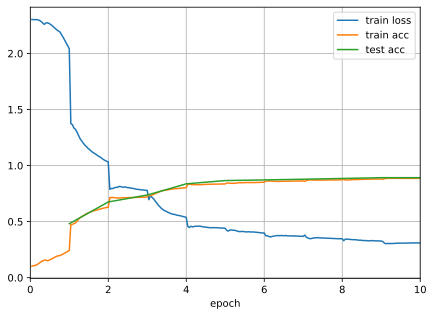

In [5]:
lr, num_epochs, batch_size = 0.1, 10, 48
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

##### Summary
+ `NiN` uses blocks consisting of a convolutional layer and multiple $1\times 1$ convolutional layer. This can be used within the convolutional stack to allow for more per-pixel nonlinearity.
+ `NiN` removes the fully connected layers and replaces them with global average pooling (i.e., summing over all locations) after reducing the number of channels to the desired number of outputs (e.g., 10 for `Fashion-MNIST`).
+ Removing the dense layers reduces overfitting. `NiN` has dramatically fewer parameters.
+ The NiN design influenced many subsequent convolutional neural networks designs.

##### Exercises
1. Tune the hyper-parameters to improve the classification accuracy.
2. Why are there two $1\times 1$ convolutional layers in the NiN block? Remove one of them, and then observe and analyze the experimental phenomena.
3. Calculate the resource usage for NiN
    + What is the number of parameters?
    + What is the amount of computation?
    + What is the amount of memory needed during training?
    + What is the amount of memory needed during inference?
4. What are possible problems with reducing the $384 \times 5 \times 5$ representation to a $10 \times 5 \times 5$ representation in one step?